# 2. Analisis Exploratorio

### Links
- [Dataset](https://eval.ai/web/challenges/challenge-page/1721/overview)
- [SentenceTransformers](https://www.sbert.net/)
- [UMAP](https://umap-learn.readthedocs.io/en/latest)
- [Plotting UMAP results](https://umap-learn.readthedocs.io/en/latest/plotting.html)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn  as sns

import numpy  as np
import pandas as pd
import torch

import logging
import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Chequeamos si se detecta la GPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-09-25 12:31:18,451 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Fijamos la semilla:

In [8]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [9]:
set_seed(42)

Parametros de la notebook:

In [10]:
DATASET_PATH = '../../datasets/fashion-outfits'

### Funciones helper

In [109]:
def plot_columns(df, x_col, y_col, title):
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=x_col, y=y_col, data=df,  orient = 'h', order = df[y_col].values)
    ax.set(xlabel=x_col)
    ax.set(ylabel=y_col)
    ax.set(yticklabels=[])
    ax.set_title(title)
    plt.show()

def plot_branch_count(df):
    plot_columns(
        df, 
        y_col = 'branch_seq', 
        x_col = 'count', 
        title = 'Cantida de productos por rama del arbol de categorias'
    )
    
def plot_title(df, column, title):
    df = df.sort_values([column], ascending=False)
    plt.figure(figsize=(8,4))
    ax = sns.barplot(x=column, y='title', data=df)
    ax.set(ylabel=None)
    ax.set(yticklabels=[])
    ax.set_title(title)
    plt.show()
    

def plot_count(ds, column, figsize=(10,4)):
    df_count = ds.groupby(column) \
        .family \
        .count() \
        .reset_index(name="Cantidad") \
        .sort_values(by='Cantidad', ascending=False)
    
    sns.set_theme(style="whitegrid")
    sns.set(rc = {'figure.figsize': figsize})
    ax = sns.barplot(y=column, x="Cantidad", data=df_count)


def bi_bar_plot(df, y, hue, figsize=(15,5), horizontal=False):
    sns.set_theme(style="whitegrid")
    sns.set(rc = {'figure.figsize': figsize})
    
    if horizontal:
        sns.barplot(data=df, y='count',x=y, hue=hue)
    else:
        sns.barplot(data=df, x='count',y=y, hue=hue)

In [88]:
branch_count = lambda df: ut.group_by_count(df, 'branch_seq', 'id').rename(columns={'id': 'count'})

def append(hash_table, key, value):
    if key not in hash_table:
        hash_table[key] = []
    hash_table[key].append(value)

def branches_to_data_frame(df, column, separator='~', null_value=None):
    count_df = df[column].value_counts()

    branches = [[v.strip() for v in value.split(separator)] for value in count_df.index]
    n_levels = max([len(b) for b in branches])
    
    data = {}
    for branch in branches:
        last_level = 0
        for level, value in enumerate(branch):
            last_level = level
            append(data, f'level_{level}', '' if value == null_value else value)

    data = pd.DataFrame(data) \
        .dropna(how='all', axis=1) \
        .dropna(axis=0)
    data['count'] = count_df.values.tolist()
    return data

def group_by_count(df, columns, count_column='id'):
    return dataset \
        .groupby(columns) \
        .count() \
        .reset_index() \
        .rename(columns={count_column: 'count'}) \
        [columns + ['count']]

## Preparar dataset

In [13]:
dataset = pd.read_csv(f'{DATASET_PATH}/all.csv')
dataset.head()

id 
 family 
 category 
 sub_category 
 description 
 highlights 
 brand 
 gender 
 materials 
 branch 
 tokens_count 
 image_uri 
 branch_seq 
 features 
 
 
 
 
 0 
 12407831 
 accessories 
 belts 
 n/d 
 Monogram Roller croc embossed belt 
 NaN 
 saint laurent 
 men 
 ['Calf Leather'] 
 accessories~belts~n/d 
 14 
 12/40/78/31/12407831.jpg 
 0 
 description: Monogram Roller croc embossed bel... 
 
 
 1 
 14461213 
 accessories 
 belts 
 n/d 
 woven belt 
 NaN 
 nicholas daley 
 men 
 ['Cotton' 'Jute'] 
 accessories~belts~n/d 
 11 
 14/46/12/13/14461213.jpg 
 0 
 description: woven belt. gender: men. brand: n... 
 
 
 2 
 14698816 
 accessories 
 belts 
 n/d 
 reversible Vintage Check belt 
 NaN 
 burberry 
 men 
 ['Thermoplastic Polyurethane (TPU)' 'Leather' ... 
 accessories~belts~n/d 
 16 
 14/69/88/16/14698816.jpg 
 0 
 description: reversible Vintage Check belt. ge... 
 
 
 3 
 16201702 
 accessories 
 belts 
 n/d 
 4G Padlock belt 
 [black, calf leather, signature 4G motif, padl... 
 givenchy 
 men 
 ['zamac' 'Calf Leather'] 
 accessories~belts~n/d 
 25 
 16/20/17/02/16201702.jpg 
 0 
 description: 4G Padlock belt. gender: men. bra... 
 
 
 4 
 16618890 
 accessories 
 belts 
 n/d 
 Greca pattern print belt 
 [black, gold-tone buckle fastening, engraved l... 
 versace 
 men 
 ['Leather' 'Fabric'] 
 accessories~belts~n/d 
 21 
 16/61/88/90/16618890.jpg 
 0 
 description: Greca pattern print belt. gender:...

# Visualización de cantidad de productos por familia, categoria y sub-categoria

La columna branch representa la rama del arbol de categorias donde se encuentra un producto.

In [14]:
branches = dataset['branch']
branches.head()

0    accessories~belts~n/d
1    accessories~belts~n/d
2    accessories~belts~n/d
3    accessories~belts~n/d
4    accessories~belts~n/d
Name: branch, dtype: object

**Observaciones**

* Se peude apreciar que cada producto se encuetra dentro de una categoria hoja dentro del un arbolde categorias.
* A su vez pertenese a una categoria padre.
* El arbol de categoroas parece tener unicamente 3 niveles.

Creamos un data frame con todas las ramas/arista del arbol de categorias, Luiego graficamos la jerarquia de categorias, especificando la cantidad de productos por cada categoria:

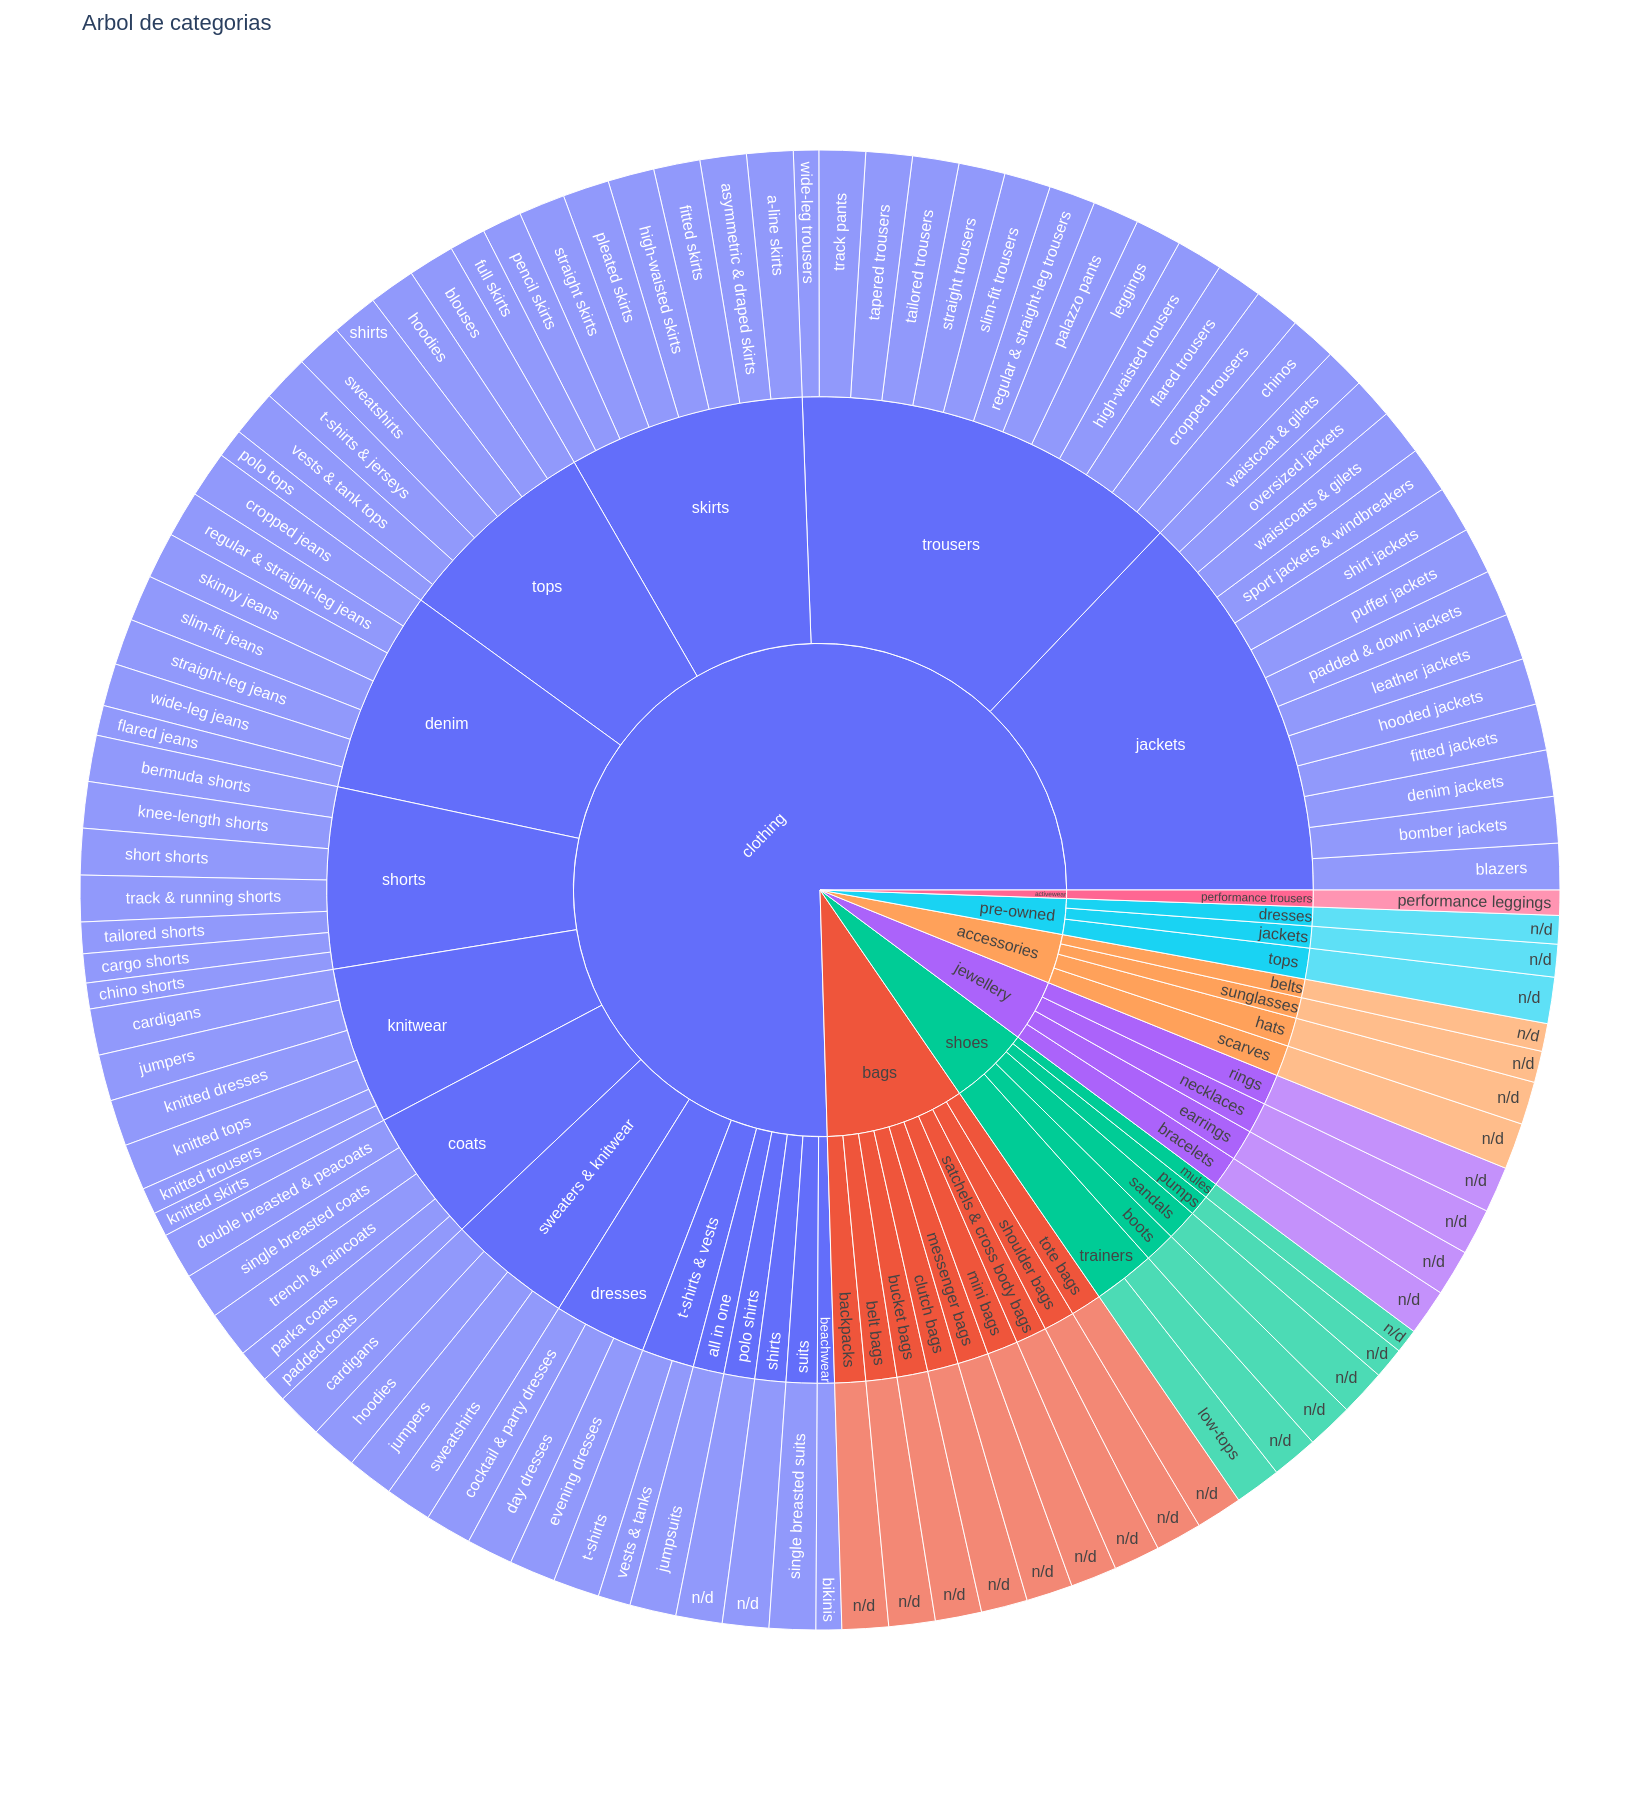

In [15]:
dt.plot_tree(
    df    = branches_to_data_frame(dataset, 'branch'), 
    title = 'Arbol de categorias'
)

## Cantidad de productos por rama

<Figure size 800x500 with 1 Axes>

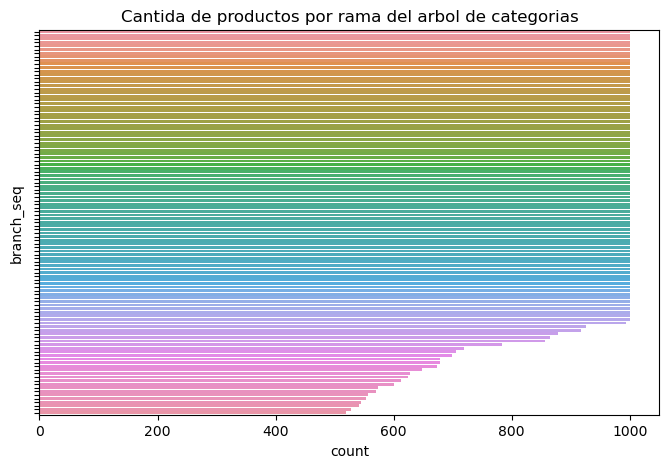

In [16]:
plot_branch_count(branch_count(dataset))

## Cantidad de productos por familia

<Figure size 1000x400 with 1 Axes>

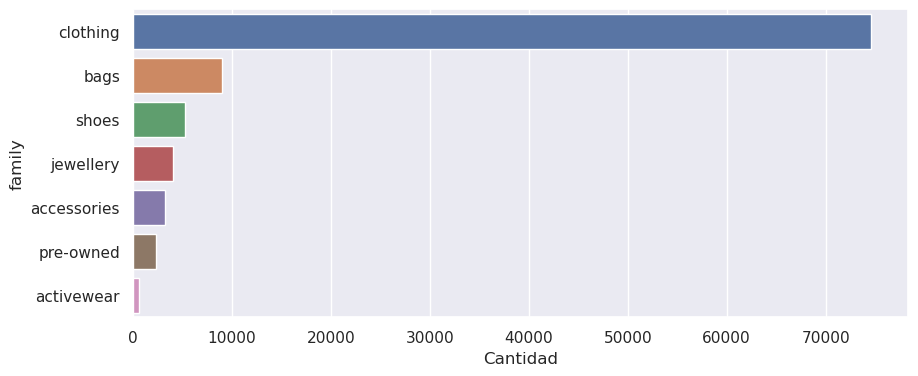

In [32]:
plot_count(dataset, 'family')

## Cantidad de productos por categoria 

<Figure size 1000x800 with 1 Axes>

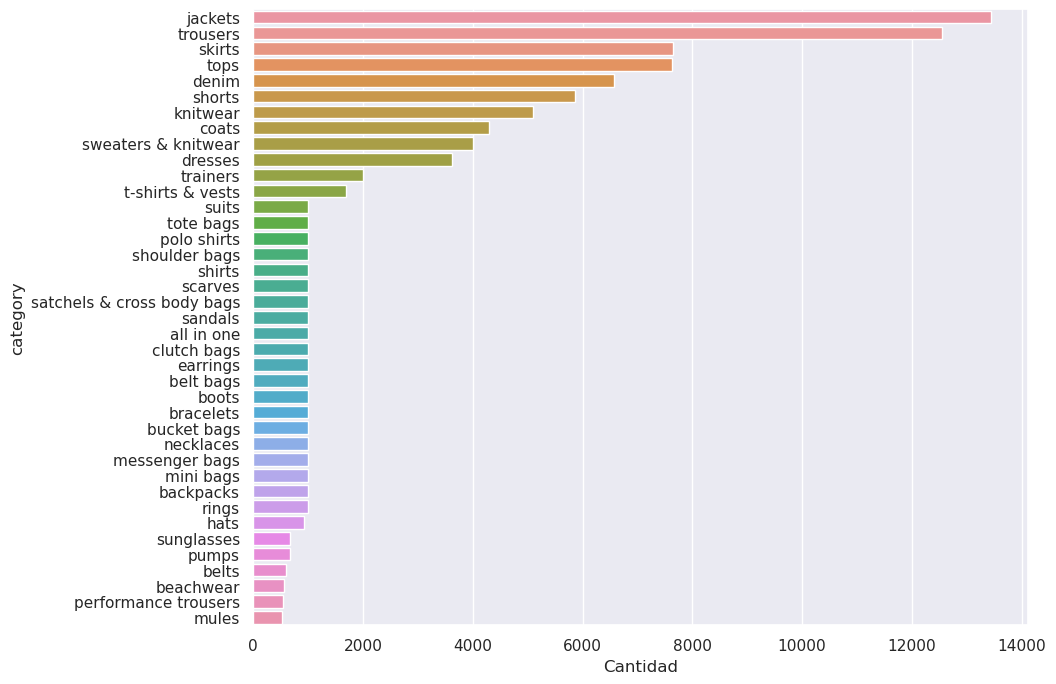

In [36]:
plot_count(dataset, 'category', figsize=(10,8))

## Cantidad de productos por sub-categoria

<Figure size 1000x1600 with 1 Axes>

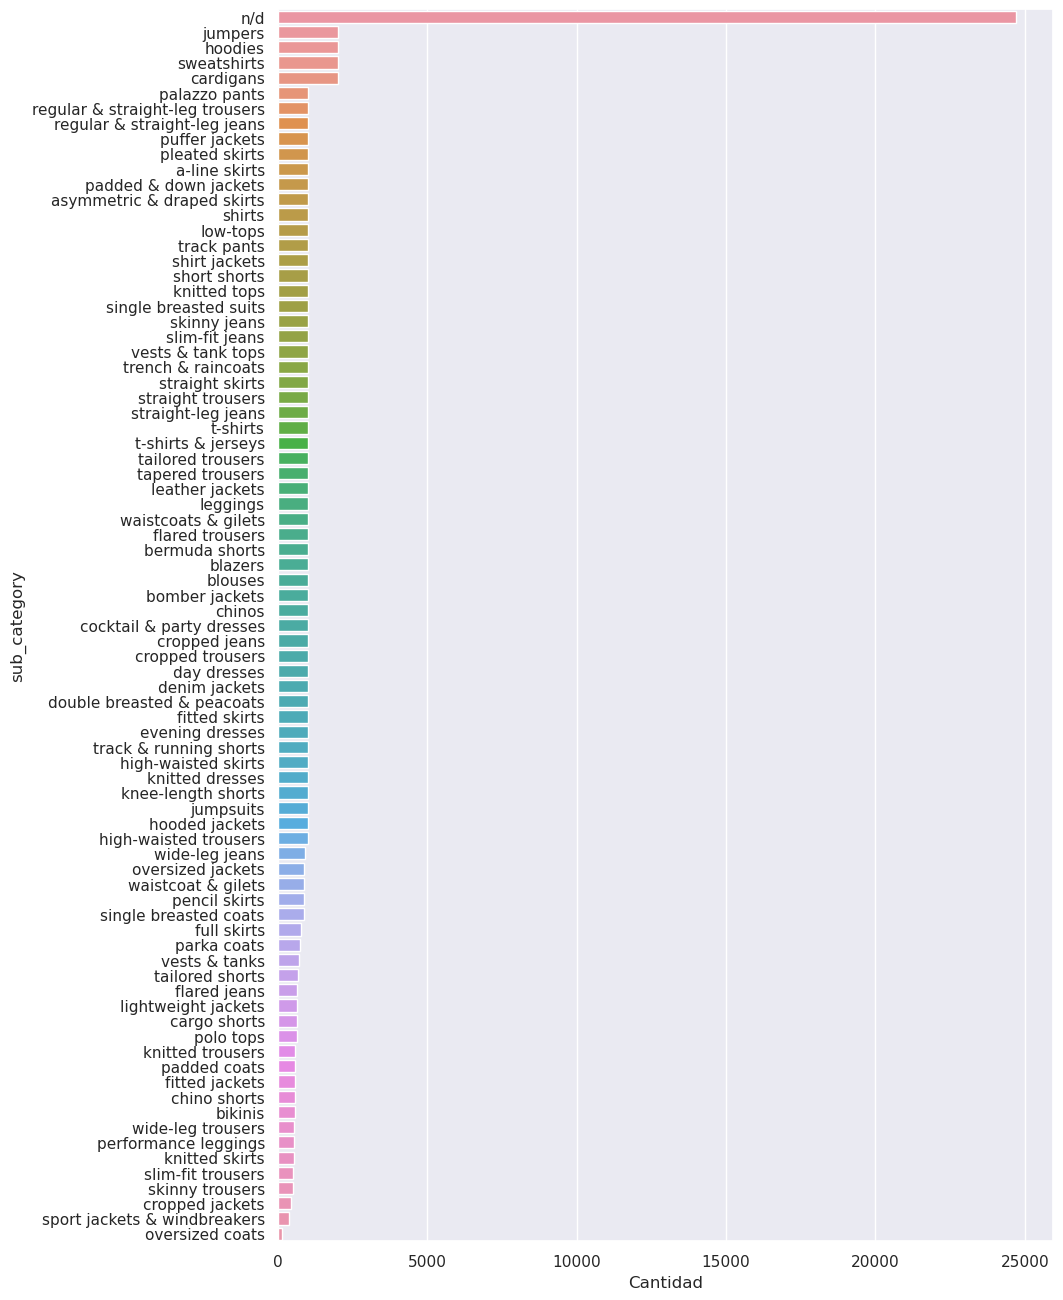

In [42]:
plot_count(dataset, 'sub_category', figsize=(10,16))

## Cantidad de generos por familia

<Figure size 1500x500 with 1 Axes>

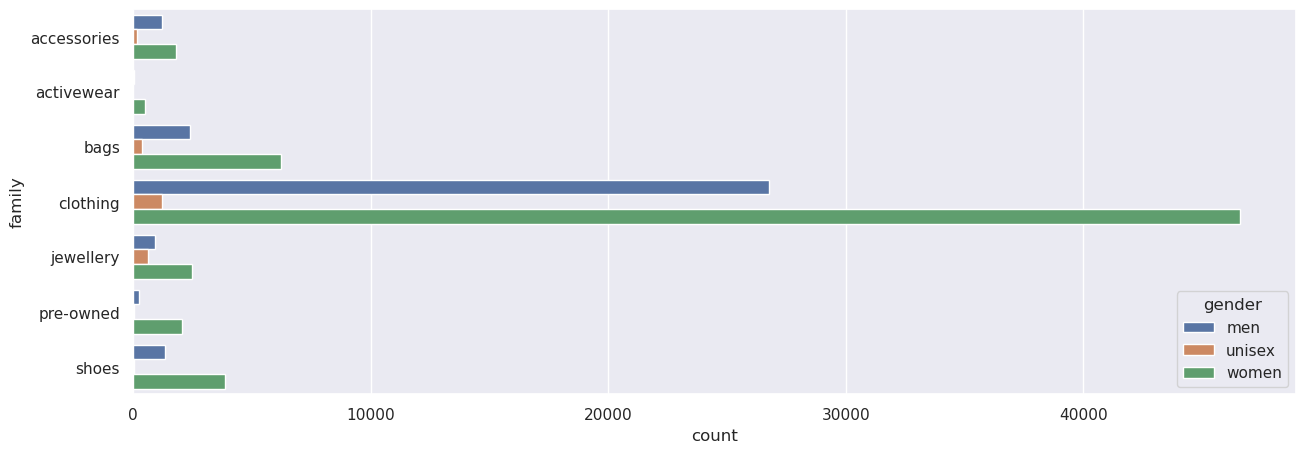

In [95]:
bi_bar_plot(
    group_by_count(dataset, ['family', 'gender']),
    'family', 
    'gender'
)

## Cantidad de productos sin sub-categorias por familia

<Figure size 800x500 with 1 Axes>

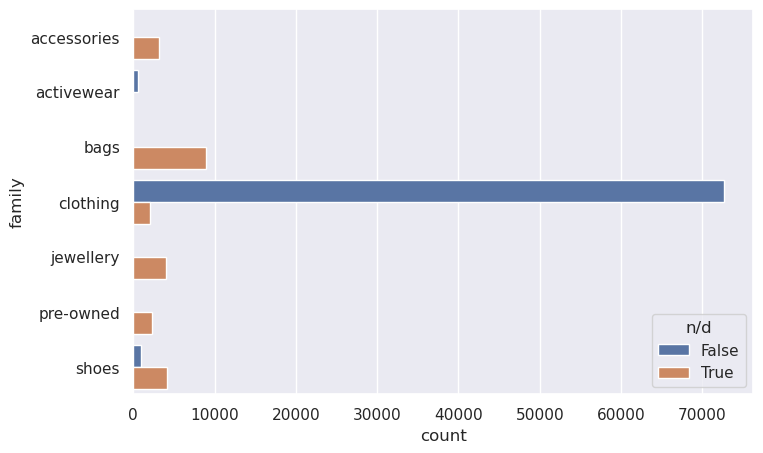

In [114]:
dataset['n/d']  = dataset['sub_category'] == 'n/d'
bi_bar_plot(
    group_by_count(dataset, ['family', 'n/d']),
    'family', 
    'n/d',
    figsize=(8,5)
)

<Figure size 1500x1000 with 1 Axes>

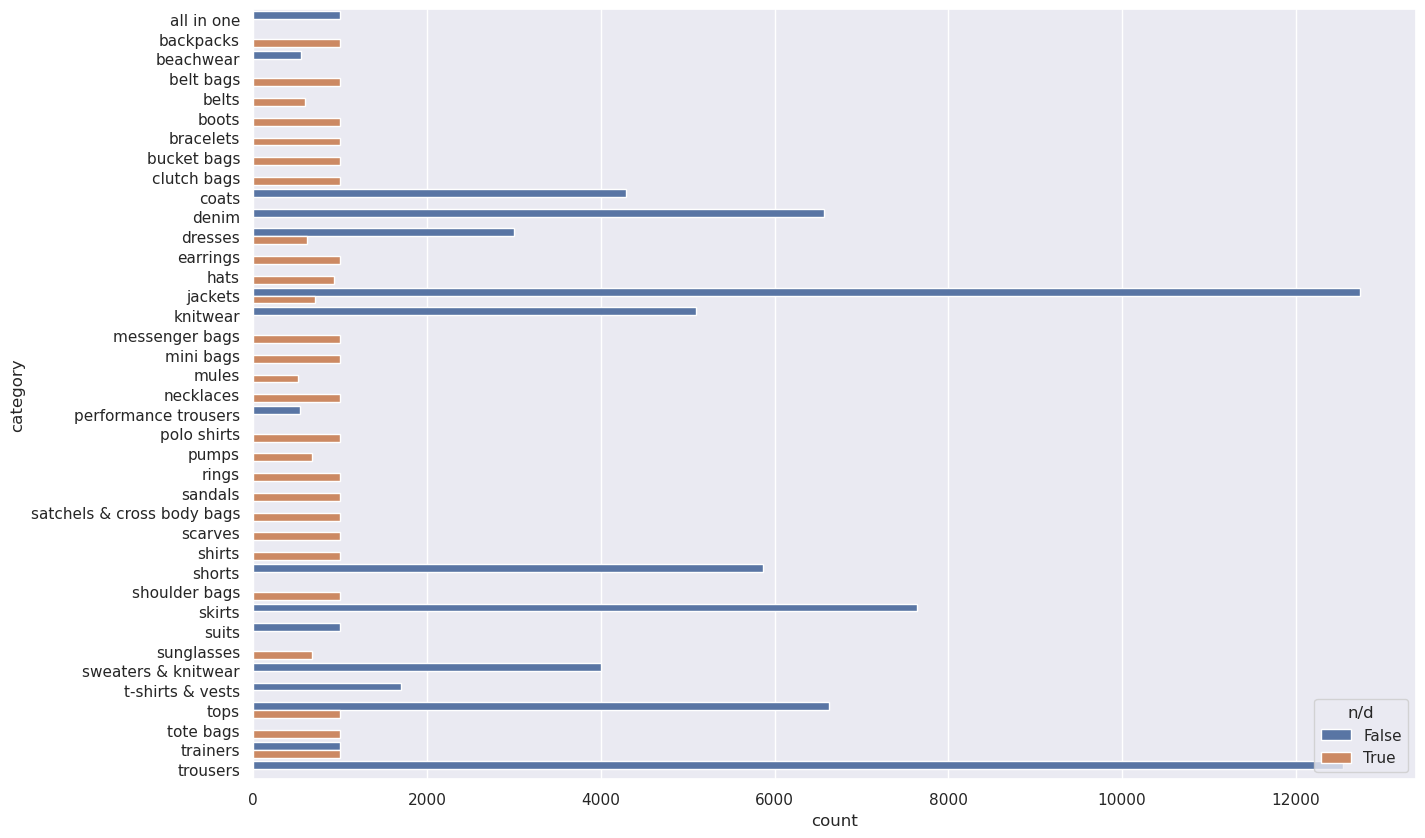

In [121]:
bi_bar_plot(
    group_by_count(dataset, ['category', 'n/d']),
    'category', 
    'n/d',
    figsize=(15, 10)
)

## Cluster de productos por rama

A continacion se generan embeddings para cada categoria y título. Luego, se reduce la dimensionalidad de los embeddings para poder graficar su similitud en dos dimensiones:

In [17]:
sentence_encoder = ml.SentenceEncoder('all-MiniLM-L6-v2')

2022-09-24 15:55:47,773 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2022-09-24 15:55:47,947 - INFO - Use pytorch device: cuda


In [18]:
branches = np.unique(dataset['branch'])

branch_embeddindgs = sentence_encoder(branches)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

)07

107

<Figure size 1000x1000 with 1 Axes>

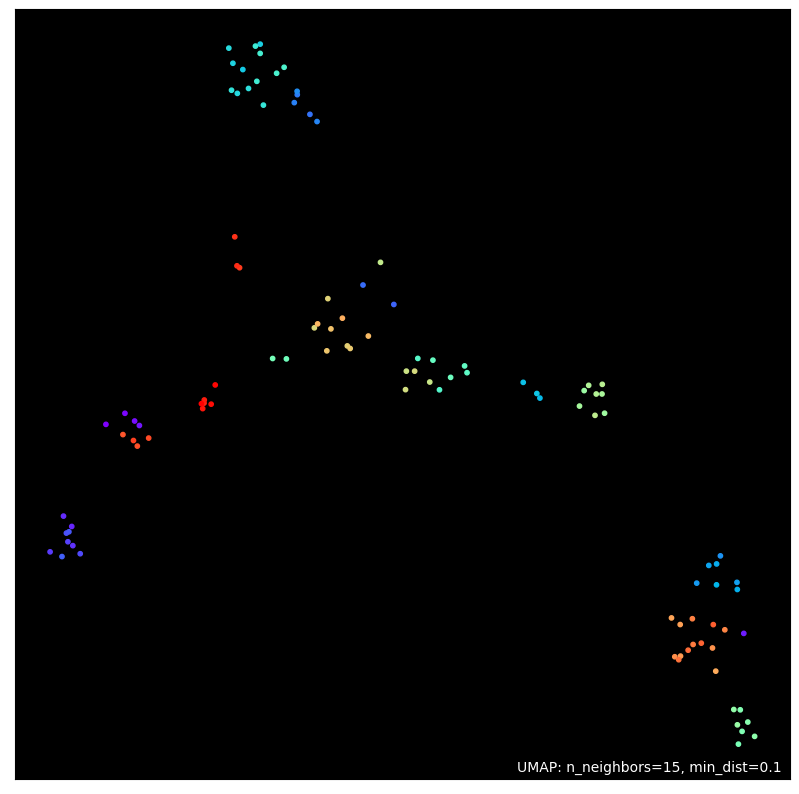

<Figure size 1000x1000 with 1 Axes>

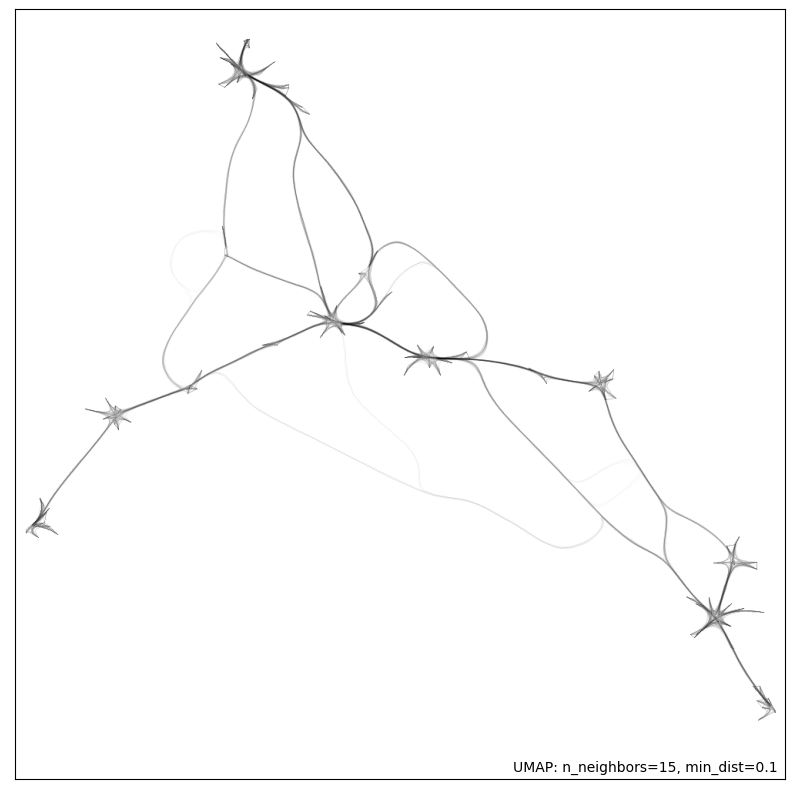

In [19]:
ml.UMAP(branch_embeddindgs) \
    .plot_clusters(labels=branches) \
    .plot_interactive_clusters(labels=branches) \
    .plot_connectivity()

len(branches)

## Cluster de productos por descriptión

A continuación, se generan embeddings para cada descripción. Luego, se reduce la dimensionalidad para visualizar la distancia entre descripciones deacuerdo a su similitud. Los colores representan las categorias a las que pertenece cada description/producto.

In [20]:
desc_cat_df = dataset[['description', 'branch']].drop_duplicates()
# desc_cat_df = desc_cat_df.sample(n=10000, random_state=1)

descs  = desc_cat_df['description'].dropna().values
labels = desc_cat_df['branch'].dropna().values

descs.shape, labels.shape

((73993,), (73996,))

In [21]:
desc_embeddindgs = sentence_encoder(descs)

Batches:   0%|          | 0/2313 [00:00<?, ?it/s]

2022-09-24 15:56:28,216 - WARNING - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<model.umap.UMAP object at 0x7f59d82c33d0>

<Figure size 1000x1000 with 1 Axes>

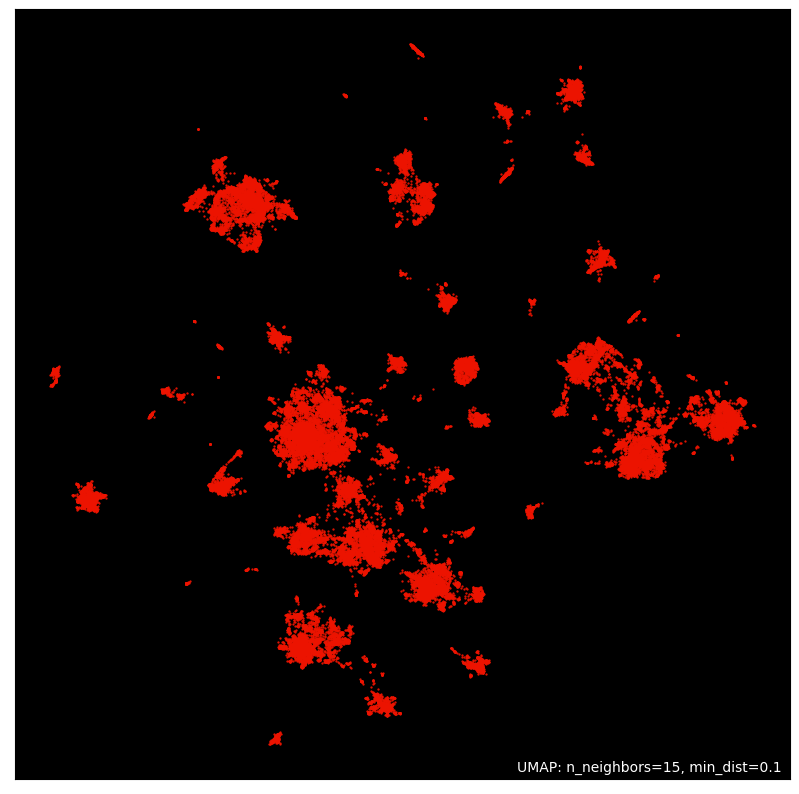

In [22]:
ml.UMAP(desc_embeddindgs).plot_clusters(labels=None)

#  Description de productos

<Figure size 1500x700 with 1 Axes>

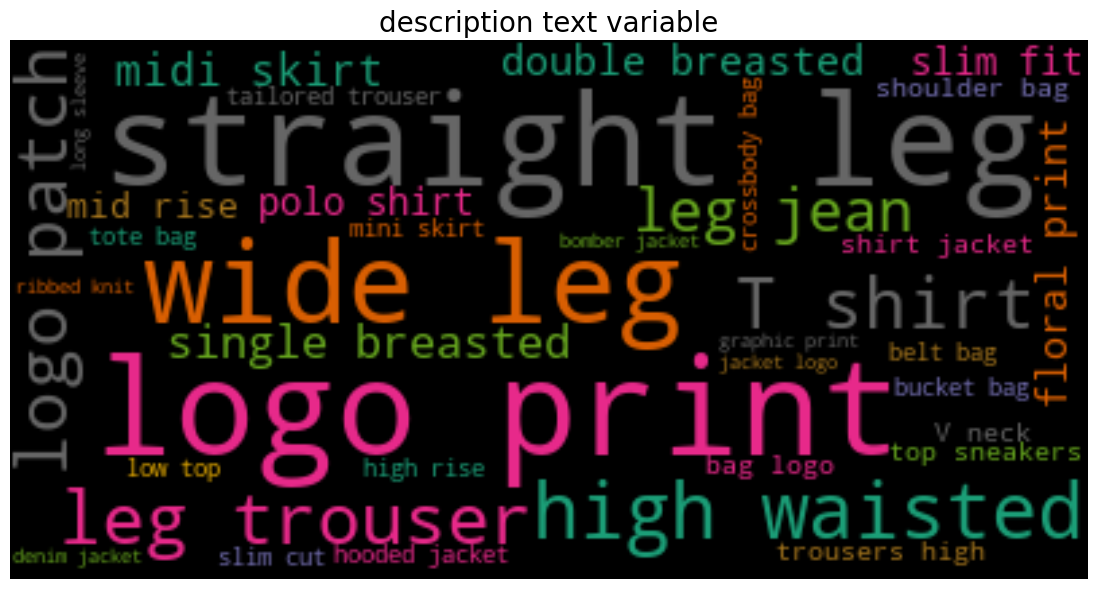

In [23]:
plt.figure(figsize=(15,7))
dataset['description'] = dataset['description'].apply(str)
dt.describe_text_var(dataset, 'description')